# 3. 複数の値を条件にしてレコードを抽出したい
ゲーム内アイテム購入データから、特定の`user_id`を持つレコードを抽出したいとします。  

In [1]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utilities.process_time import PandasProcessTimeMeasure

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
item_data = pd.read_csv('./data/game_user_item.csv')
item_data.head(5)

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
1,9634,2018-05-23,4,item004,4,6000
2,5936,2018-05-28,10,item010,4,6000
3,6635,2018-03-08,9,item009,0,0
4,8864,2018-05-27,9,item009,0,0


このような場合、

```python
is_user1 = (item_data.user_id == 1)
is_user2 = (item_data.user_id == 2)
is_user3 = (item_data.user_id == 3)
item_data.loc[is_user1 & is_user2 & is_user3, :]
```

とすると処理効率が1番良さそうです。  
しかし、データ分析では特定の条件を満たすユーザーを抽出したい場合がほとんどなので、　このように少数が対象になることはなく、また、対象者数は変動するものなので、このコードは採用しづらいです。  
そこでDataFrameに実装されている`isin`メソッドを使うと

```python
target_user_id = [1, 2, 3]
item_data.loc[item_data.user_id.isin(target_user_id), :]
```

となり、target_user_idを外部変数として与えることが簡単になるので、運用しやすいコードが書けます。   
しかし、この`isin`メソッドはなぜか動作が遅く、1000万件のデータに対して使えないことが問題になります。  
今回はこの場合について検証します。

## 方法1　isinメソッドを使った場合
まずはベンチマークとして`isin`メソッドを使った方法です。  
コードの記述が完結になるのが１番の魅力です。

In [18]:
TEST_TARGET_USER_ID = [2855, 6635]

In [19]:
def method1(data, user_id):
    _data = data.copy()
    is_target_user = _data.user_id.isin(user_id)
    result = _data.loc[is_target_user, :]
    return result

method1(item_data.iloc[:100, :], TEST_TARGET_USER_ID).head()

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
3,6635,2018-03-08,9,item009,0,0


## 方法2　mapで対象アイテムにフラグを立てて抽出する
次は`map`メソッドを使って抽出対象にフラグを立てて抽出する方法です。  
`isin`メソッドの場合と同じような気がしますが、一応、検証してみます。

In [20]:
def method2(data, user_id):
    _data = data.copy()
    is_target_user = _data.user_id.map(lambda i: i in user_id)
    result = _data.loc[is_target_user, :]
    return result

method2(item_data.iloc[:100, :], TEST_TARGET_USER_ID).head()

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
3,6635,2018-03-08,9,item009,0,0


## 方法3　mergeを使って抽出対象にフラグを立てて抽出する

In [22]:
def method3(data, user_id):
    _data = data.copy()
    flag_table = pd.DataFrame(
        data={
            'user_id': user_id,
            'is_target': [1] * len(user_id)
        }
    )
    tmp = _data.merge(
        right=flag_table,
        on=['user_id'],
        how='left'
    )
    result = tmp.loc[tmp.is_target == 1, :].copy()
    return result

method3(item_data.iloc[:100,:], TEST_TARGET_USER_ID).head()

,user_id,date,item_id,item_name,item_purchase_count,payment,is_target
0,2855,2018-04-14,5,item005,4,6000,1.0
3,6635,2018-03-08,9,item009,0,0,1.0


## 検証結果
### 対象者数を10に限定して、方法1〜3を20000件までのデータで比較

In [11]:
def generate_target_user_id_list(n):
    user_id_list = item_data.user_id.unique()
    return np.random.choice(user_id_list, size=n).tolist()

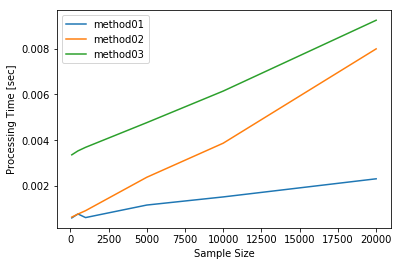

In [23]:
TARGET_USER_ID = generate_target_user_id_list(10)
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[100, 500, 1000, 5000, 10000, 20000]
)
process_time_measure.set_method(name='method01', method=lambda x: method1(x, TARGET_USER_ID))
process_time_measure.set_method(name='method02', method=lambda x: method2(x, TARGET_USER_ID))
process_time_measure.set_method(name='method03', method=lambda x: method3(x, TARGET_USER_ID))
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [8]:
process_time_measure.process_time

,method01,method02,method03
sample_size,,,
100,0.000600,0.000646,0.003256
500,0.000625,0.000767,0.003516
1000,0.000664,0.000908,0.003605
5000,0.001037,0.002019,0.004828
10000,0.001294,0.003389,0.007595
20000,0.001998,0.006334,0.010263


### 1000万件までのデータで方法1〜3を比較する

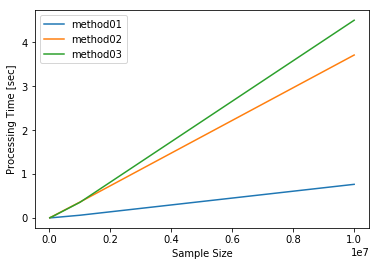

In [24]:
TARGET_USER_ID = generate_target_user_id_list(10)
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[10000, 50000, 100000, 1000000, 10000000]
)
process_time_measure.set_method(name='method01', method=lambda x: method1(x, TARGET_USER_ID))
process_time_measure.set_method(name='method02', method=lambda x: method2(x, TARGET_USER_ID))
process_time_measure.set_method(name='method03', method=lambda x: method3(x, TARGET_USER_ID))
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [25]:
process_time_measure.process_time

,method01,method02,method03
sample_size,,,
10000,0.001141,0.004132,0.006308
50000,0.003832,0.018723,0.018103
100000,0.006693,0.037572,0.032707
1000000,0.062318,0.362686,0.356687
10000000,0.766330,3.711612,4.503969


### 抽出対象ユーザー数を変化させて方法1〜3を検証

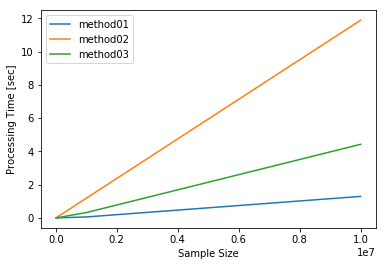

In [26]:
TARGET_USER_ID = generate_target_user_id_list(100)
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[10000, 50000, 100000, 1000000, 10000000]
)
process_time_measure.set_method(name='method01', method=lambda x: method1(x, TARGET_USER_ID))
process_time_measure.set_method(name='method02', method=lambda x: method2(x, TARGET_USER_ID))
process_time_measure.set_method(name='method03', method=lambda x: method3(x, TARGET_USER_ID))
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [30]:
process_time_100 = process_time_measure.process_time.copy()
user_num_index = pd.Series([100] * process_time_100.shape[0])
user_num_index.name = 'user_num'
process_time_100.set_index(user_num_index, append=True, inplace=True)
process_time_100

,,method01,method02,method03
sample_size,user_num,,,
10000,100,0.001220,0.012318,0.006921
50000,100,0.004808,0.059381,0.017635
100000,100,0.007025,0.118754,0.031300
1000000,100,0.059562,1.187032,0.322207
10000000,100,1.294282,11.883588,4.424374


`method2`は遅いので除外し、`method1`と`method3`のみを比較する。

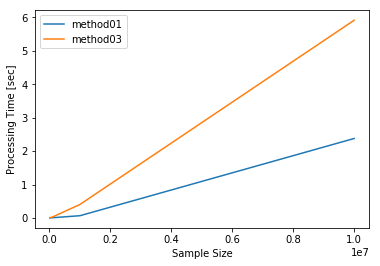

In [31]:
TARGET_USER_ID = generate_target_user_id_list(500)
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[10000, 50000, 100000, 1000000, 10000000]
)
process_time_measure.set_method(name='method01', method=lambda x: method1(x, TARGET_USER_ID))
process_time_measure.set_method(name='method03', method=lambda x: method3(x, TARGET_USER_ID))
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

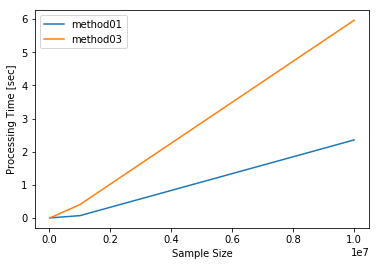

In [32]:
TARGET_USER_ID = generate_target_user_id_list(1000)
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[10000, 50000, 100000, 1000000, 10000000]
)
process_time_measure.set_method(name='method01', method=lambda x: method1(x, TARGET_USER_ID))
process_time_measure.set_method(name='method03', method=lambda x: method3(x, TARGET_USER_ID))
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

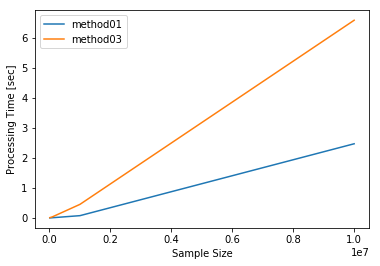

In [33]:
TARGET_USER_ID = generate_target_user_id_list(5000)
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[10000, 50000, 100000, 1000000, 10000000]
)
process_time_measure.set_method(name='method01', method=lambda x: method1(x, TARGET_USER_ID))
process_time_measure.set_method(name='method03', method=lambda x: method3(x, TARGET_USER_ID))
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()